In [268]:
%load_ext autoreload
%autoreload 2
import os, sys
sys.path.append('..')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")
%load_ext line_profiler
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (11,8)
from sklearn.ensemble import RandomForestRegressor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [255]:
from merf.utils import MERFDataGenerator
#from merf.merf import MERF
from merf.merf2 import MERF

# Test Data Generation

In [202]:
dgm = MERFDataGenerator(m=.6, sigma_b=np.sqrt(4.5), sigma_e=1)

In [203]:
num_clusters_each_size = 20
train_sizes = [1, 3, 5, 7, 9]
known_sizes = [9, 27, 45, 63, 81]
new_sizes = [10, 30, 50, 70, 90]

In [204]:
# Smaller set that can be used for debugging
# num_clusters_each_size = 1
# train_sizes = [1, 3]
# known_sizes = [9, 27]
# new_sizes = [10, 30]

In [205]:
train_cluster_sizes = MERFDataGenerator.create_cluster_sizes_array(train_sizes, num_clusters_each_size)
known_cluster_sizes = MERFDataGenerator.create_cluster_sizes_array(known_sizes, num_clusters_each_size)
new_cluster_sizes = MERFDataGenerator.create_cluster_sizes_array(new_sizes, num_clusters_each_size)

In [206]:
len(train_cluster_sizes), len(known_cluster_sizes), len(new_cluster_sizes)

(100, 100, 100)

In [207]:
train, test_known, test_new, training_cluster_ids, ptev, prev = dgm.generate_split_samples(train_cluster_sizes, known_cluster_sizes, new_cluster_sizes)

INFO     [utils.py:165] Drew 10000 samples from 200 clusters.
INFO     [utils.py:166] PTEV = 89.92020128376375, PREV = 50.443719626385345.


In [208]:
len(train), len(test_known), len(test_new)

(500, 4500, 5000)

In [209]:
train.head()

,y,X_0,X_1,X_2,Z,cluster
0,2.031770,-1.432914,0.699269,1.427526,1.0,0
10,2.355572,0.588588,-1.636062,-0.224138,1.0,1
20,4.807960,0.223753,0.804050,-2.249484,1.0,2
30,4.561850,1.340813,-0.173084,-0.622559,1.0,3
40,-2.933981,-0.118698,-0.438668,1.303432,1.0,4


# MERF Training

In [210]:
X_train = train[['X_0', 'X_1', 'X_2']]
Z_train = train[['Z']]
clusters_train = train['cluster']
y_train = train['y']

## Default MERF

In [211]:
mrf = MERF(max_iterations=30)
mrf.fit(X_train, Z_train, clusters_train, y_train)

INFO     [merf2.py:261] GLL is -49.22801375207455 at iteration 1.
INFO     [merf2.py:261] GLL is -55.517158984825244 at iteration 2.
INFO     [merf2.py:261] GLL is -64.49751905122895 at iteration 3.
INFO     [merf2.py:261] GLL is -82.23986150694101 at iteration 4.
INFO     [merf2.py:261] GLL is -59.9104111782801 at iteration 5.
INFO     [merf2.py:261] GLL is -66.28080469458756 at iteration 6.
INFO     [merf2.py:261] GLL is -55.99206189375333 at iteration 7.
INFO     [merf2.py:261] GLL is -72.13603961454118 at iteration 8.
INFO     [merf2.py:261] GLL is -57.82519471586706 at iteration 9.
INFO     [merf2.py:261] GLL is -55.39585695845699 at iteration 10.
INFO     [merf2.py:261] GLL is -80.77126664584397 at iteration 11.
INFO     [merf2.py:261] GLL is -53.892349188887344 at iteration 12.
INFO     [merf2.py:261] GLL is -67.6157754472996 at iteration 13.
INFO     [merf2.py:261] GLL is -73.7349956453194 at iteration 14.
INFO     [merf2.py:261] GLL is -65.7715729583911 at iteration 15.
INFO  

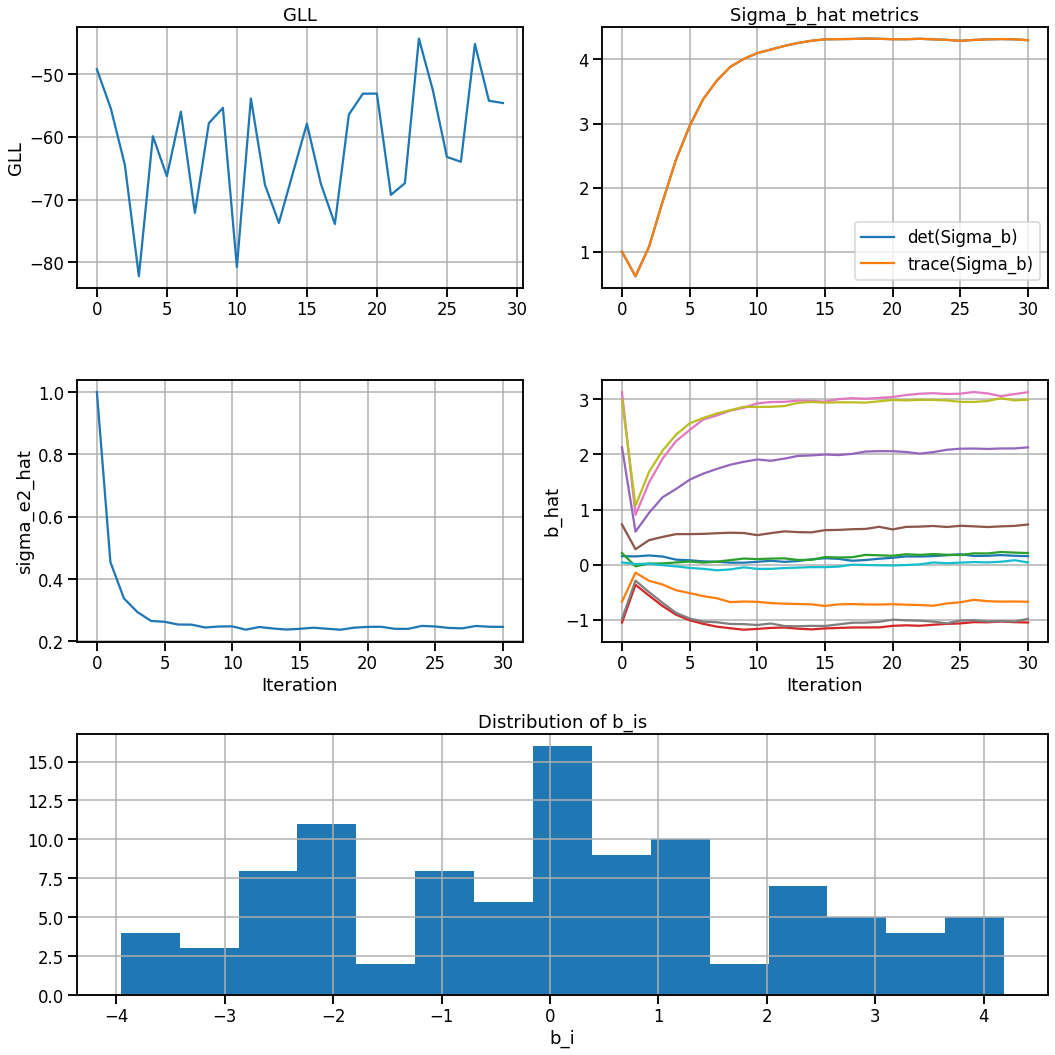

In [273]:
from merf.evaluator import plot_training_stats
plot_training_stats(mrf, num_clusters_to_plot=10)

## LightGBM

In [277]:
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor()

In [278]:
mrf_lgbm = MERF(lgbm, max_iterations=30)
mrf_lgbm.fit(X_train, Z_train, clusters_train, y_train)

INFO     [merf2.py:261] GLL is 468.4039546639342 at iteration 1.
INFO     [merf2.py:261] GLL is 431.10611984855905 at iteration 2.
INFO     [merf2.py:261] GLL is 376.6240066919337 at iteration 3.
INFO     [merf2.py:261] GLL is 364.9738326644687 at iteration 4.
INFO     [merf2.py:261] GLL is 361.9821007387047 at iteration 5.
INFO     [merf2.py:261] GLL is 347.1027252583366 at iteration 6.
INFO     [merf2.py:261] GLL is 352.6619027724553 at iteration 7.
INFO     [merf2.py:261] GLL is 349.83491705199856 at iteration 8.
INFO     [merf2.py:261] GLL is 350.94554138560886 at iteration 9.
INFO     [merf2.py:261] GLL is 357.75282586774057 at iteration 10.
INFO     [merf2.py:261] GLL is 353.7079126257747 at iteration 11.
INFO     [merf2.py:261] GLL is 354.00195128262806 at iteration 12.
INFO     [merf2.py:261] GLL is 362.48490420074927 at iteration 13.
INFO     [merf2.py:261] GLL is 365.40086778755744 at iteration 14.
INFO     [merf2.py:261] GLL is 348.73480477823944 at iteration 15.
INFO     [m

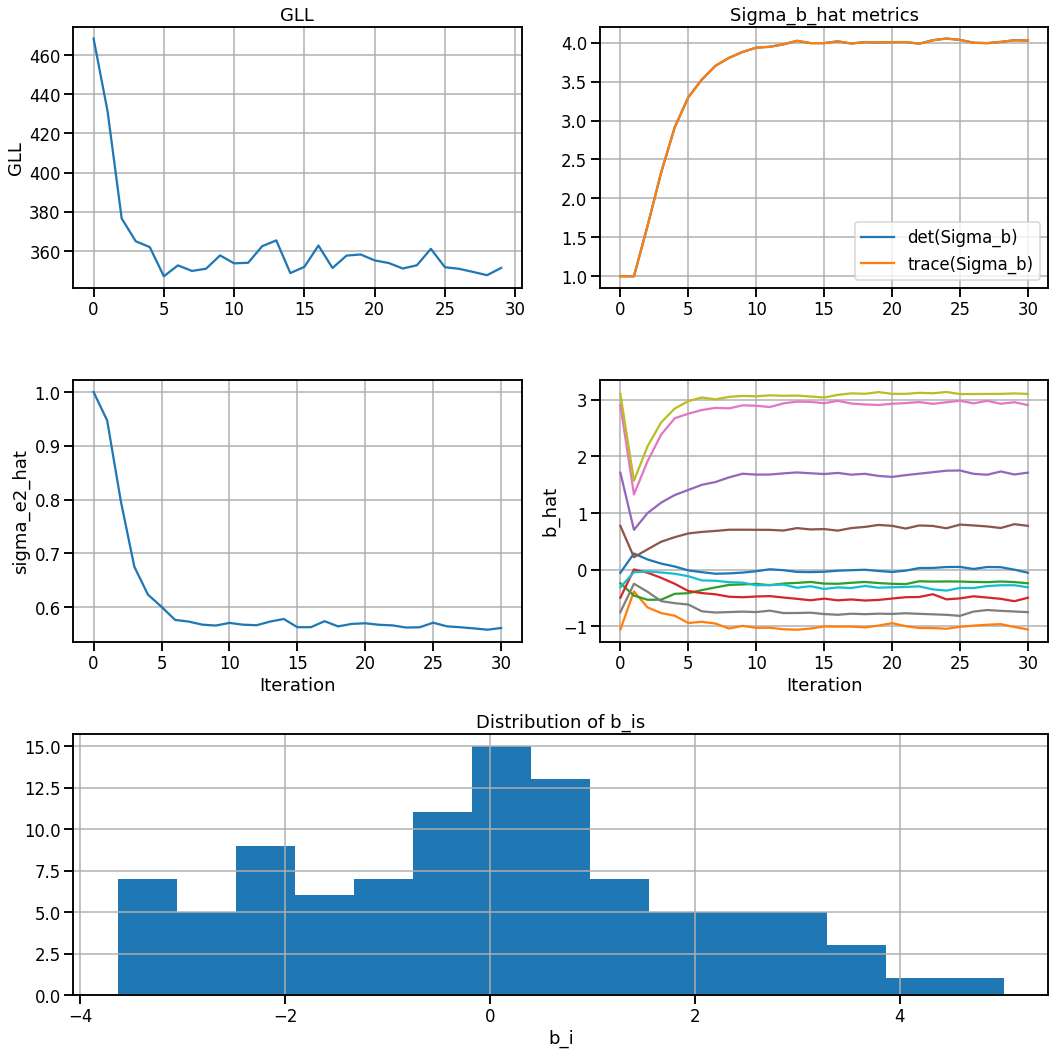

In [279]:
plot_training_stats(mrf_lgbm, num_clusters_to_plot=10)

# MERF Prediction

In [124]:
X_known = test_known[['X_0', 'X_1', 'X_2']]
Z_known = test_known[['Z']]
clusters_known = test_known['cluster']
y_known = test_known['y']

In [125]:
y_hat_known = mrf.predict(X_known, Z_known, clusters_known)
y_hat_known

array([-3.33786179,  1.0196584 , -0.3901869 , ...,  2.14927357,
       -0.63566302,  4.29675591])

In [126]:
assert len(y_hat_known) == len(y_known)

In [127]:
X_new = test_new[['X_0', 'X_1', 'X_2']]
Z_new = test_new[['Z']]
clusters_new = test_new['cluster']
y_new = test_new['y']

In [128]:
y_hat_new = mrf.predict(X_new, Z_new, clusters_new)
y_hat_new

array([ 4.22179162,  2.22037092,  1.1392021 , ...,  1.19191813,
       -1.12569847,  1.82051881])

In [129]:
assert len(y_hat_new) == len(y_new)

# Inspect Trained Random Forest

Specifically look at the partial dependence plots and feature importance (using SHAP). 

In [130]:
mrf.trained_fe_model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [132]:
from sklearn.inspection import plot_partial_dependence

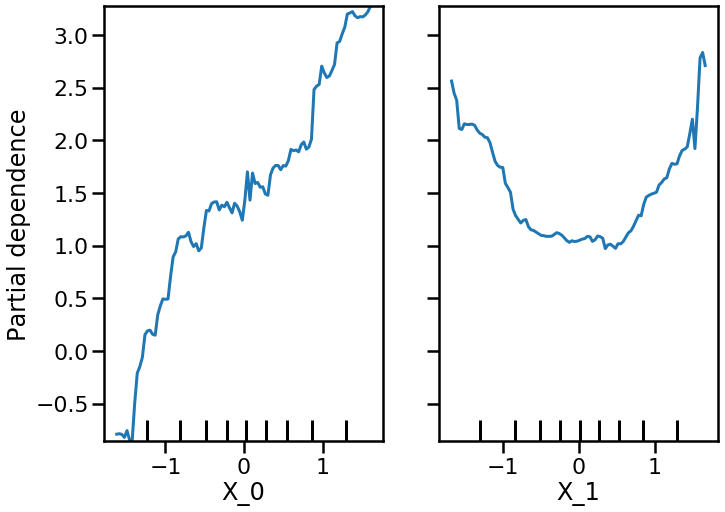

In [133]:
features = [0, 1]
plot_partial_dependence(mrf.trained_fe_model, X_known, features) 

In [134]:
import shap

In [135]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(mrf.trained_fe_model)
shap_values = explainer.shap_values(X_known)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


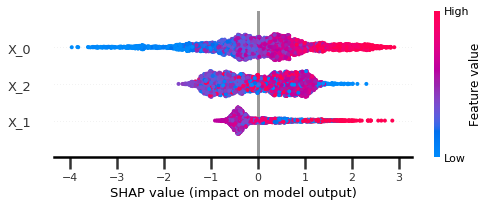

In [136]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_known)

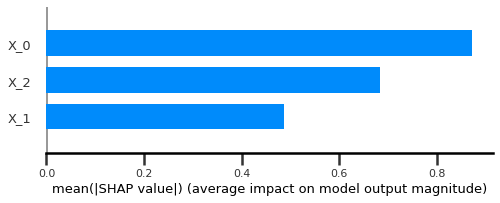

In [137]:
shap.summary_plot(shap_values, X_known, plot_type="bar")


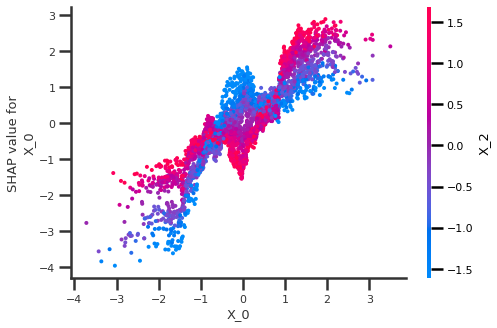

In [138]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('X_0', shap_values, X_known)

# MERF vs. Random Forest on Fixed Effects

In [ ]:
# Train and test using classic random forest. 
from sklearn.ensemble import RandomForestRegressor
import numpy as np

In [ ]:
rf = RandomForestRegressor(n_estimators=300, n_jobs=-1)

In [ ]:
rf.fit(X_train, y_train)

In [ ]:
y_hat_known_rf = rf.predict(X_known)

In [ ]:
pmse_known_rf = np.mean((y_known - y_hat_known_rf) ** 2)
pmse_known_rf

In [ ]:
y_hat_known_merf = mrf.predict(X_known, Z_known, clusters_known)

In [ ]:
pmse_known_merf = np.mean((y_known - y_hat_known_merf) ** 2)
pmse_known_merf

In [ ]:
rd_known = 100 * (pmse_known_rf - pmse_known_merf) / pmse_known_rf
rd_known

In [ ]:
y_hat_new_rf = rf.predict(X_new)

In [ ]:
pmse_new_rf = np.mean((y_new - y_hat_new_rf) ** 2)
pmse_new_rf

In [ ]:
y_hat_new_merf = mrf.predict(X_new, Z_new, clusters_new)

In [ ]:
pmse_new_merf = np.mean((y_new - y_hat_new_merf) ** 2)
pmse_new_merf

In [ ]:
rd_new = 100 * (pmse_new_rf - pmse_new_merf) / pmse_new_rf
rd_new

# MERF vs Random Forest with OHE Cluster Ids

In [ ]:
rf_ohe = RandomForestRegressor(n_estimators=300, n_jobs=-1)

In [ ]:
categories = np.sort(clusters_train.unique())

In [ ]:
clusters_train_prime = pd.Categorical(clusters_train, categories=categories)

In [ ]:
X_ohe = pd.get_dummies(clusters_train_prime, prefix='cluster')

In [ ]:
X_ohe.head()

In [ ]:
X_train_ohe = pd.merge(X_train, X_ohe, left_index=True, right_index=True)

In [ ]:
rf_ohe.fit(X_train_ohe, y_train)

In [ ]:
clusters_known_prime = pd.Categorical(clusters_known, categories=categories)

In [ ]:
X_known_ohe = pd.get_dummies(clusters_known_prime, prefix='cluster')

In [ ]:
X_known_ohe.head()

In [ ]:
X_known_w_ohe = pd.merge(X_known, X_known_ohe, left_index=True, right_index=True)

In [ ]:
y_hat_known_rf_ohe = rf_ohe.predict(X_known_w_ohe)

In [ ]:
mse_known_rf_ohe = np.mean((y_known - y_hat_known_rf_ohe) ** 2)
mse_known_rf_ohe

In [ ]:
clusters_new_prime = pd.Categorical(clusters_new, categories=categories)

In [ ]:
X_new_ohe = pd.get_dummies(clusters_new_prime, prefix='cluster')

In [ ]:
X_new_ohe.head()

In [ ]:
X_new_w_ohe = pd.merge(X_new, X_new_ohe, left_index=True, right_index=True)

In [ ]:
y_hat_new_rf_ohe = rf_ohe.predict(X_new_w_ohe)

In [ ]:
mse_new_rf_ohe = np.mean((y_new - y_hat_new_rf_ohe) ** 2)
mse_new_rf_ohe